In [45]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import spacy

from collections import Counter
from functools import partial
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models.wrappers import LdaMallet
from tqdm import tqdm

# Places

In [2]:
term = 'restaurant'

In [3]:
data_path = './../data'

df_yelp = pd.read_csv(os.path.join(data_path, 'yelp_{}.csv'.format(term)))
df_yelp_review = pd.read_csv(os.path.join(data_path, 'yelp_{}_review.csv'.format(term)))
df_google = pd.read_csv(os.path.join(data_path, 'google_{}.csv'.format(term)))
df_google_review = pd.read_csv(os.path.join(data_path, 'google_{}_review.csv'.format(term)))

In [4]:
df_yelp.id.count()

6064

In [5]:
df_yelp_sub = df_yelp[['id', 'neighborhood']]
df_yelp_sub = df_yelp_sub[df_yelp_sub.neighborhood.notna()]
df_yelp_sub

,id,neighborhood
0,AJ1SJkAVv1H6lA4pDnZ0dQ,San Ysidro
1,uGt9jvS6tcPpYhJa1kDl1w,San Ysidro
2,9BeEPZ4p0iEHYyKLYBLRBw,San Ysidro
3,Ws4nOG8u2uSTUqEA28a30Q,San Ysidro
4,bN2HUTEFnzSKVJI4dxvkhQ,San Ysidro
...,...,...
6052,dkucfVkD6mnbNzIFjhtU4w,Rancho Bernardo
6060,U3il5we3ZoN8mK6H0lBz9A,La Costa
6061,cVVxcRO-m-ObsuYD3thxLQ,La Costa
6062,EIC1EkoJMxc3U3LgQY4P7w,La Costa


In [6]:
df_google.place_id.count()

6130

In [7]:
df_google_sub = df_google[['place_id', 'neighborhood']]
df_google_sub = df_google_sub[df_google_sub.neighborhood.notna()]
df_google_sub

,place_id,neighborhood
0,ChIJtX9_3j5J2YARzcOEJYdwtl0,San Ysidro
1,ChIJ4_64EO5J2YARAMrG3WMF9mA,San Ysidro
2,ChIJe5v-Nj9J2YARSn1g21LS7xc,San Ysidro
3,ChIJiczf5z5J2YARKpv-rNf_85A,San Ysidro
4,ChIJzcwtNz9J2YARG4A4O5fGYc8,San Ysidro
...,...,...
6125,ChIJyU5LY-H424ARfnGTWfmh3D0,Mira Mesa
6126,ChIJK7eJzR7524ARN3IUb4SjFZE,Mira Mesa
6127,ChIJt4P-0h7524ARn9-4Zst9LiM,Mira Mesa
6128,ChIJATBzyx7524ARobcQ2pYyF5c,Mira Mesa


# Reviews

In [8]:
df_yelp_review.id.count()

17428

In [9]:
df_yelp_review_sub = df_yelp_review[['business_id', 'text', 'rating']]
df_yelp_review_sub = df_yelp_review_sub[df_yelp_review_sub.text.notna()]
df_yelp_review_sub

,business_id,text,rating
0,AJ1SJkAVv1H6lA4pDnZ0dQ,The food is good.. not many lunch selections o...,4.0
1,AJ1SJkAVv1H6lA4pDnZ0dQ,"First, the lady looked like more of fighting w...",2.0
2,AJ1SJkAVv1H6lA4pDnZ0dQ,Use to enjoy the food their once in a while. P...,2.0
3,uGt9jvS6tcPpYhJa1kDl1w,Best Birria I've ever had in my life! Wow \nTh...,5.0
4,uGt9jvS6tcPpYhJa1kDl1w,"If you're looking for some delicious, fresh, a...",5.0
...,...,...,...
17423,EIC1EkoJMxc3U3LgQY4P7w,Incredible food! Burritos are gigantic. Also f...,5.0
17424,EIC1EkoJMxc3U3LgQY4P7w,The lady behind the counter is extremely STING...,1.0
17425,caquwLQ2wuApa618uL3YQg,Always come here every time I'm in town. I wis...,5.0
17426,caquwLQ2wuApa618uL3YQg,I am very dissapointed about the costumer serv...,1.0


In [10]:
df_google_review.place_id.count()

27283

In [11]:
df_google_review_sub = df_google_review[['place_id', 'text', 'rating']]
df_google_review_sub = df_google_review_sub[df_google_review_sub.text.notna()]
df_google_review_sub

,place_id,text,rating
0,ChIJtX9_3j5J2YARzcOEJYdwtl0,One of my Favorites place to eat for years,5
1,ChIJtX9_3j5J2YARzcOEJYdwtl0,I come here all the time for lunch and usually...,1
2,ChIJtX9_3j5J2YARzcOEJYdwtl0,Excellent. My #1 stop for lunch.,5
3,ChIJtX9_3j5J2YARzcOEJYdwtl0,I have been going to this subway for about 5 y...,5
4,ChIJtX9_3j5J2YARzcOEJYdwtl0,"they ALWAYS, ALWAYS make the online orders wro...",1
...,...,...,...
27278,ChIJDWgYEuL424ARcHF4d8v2DDk,Open for indoor dining as of 09/10/2020. Class...,5
27279,ChIJDWgYEuL424ARcHF4d8v2DDk,This place is no doubt one of the best place t...,5
27280,ChIJDWgYEuL424ARcHF4d8v2DDk,Korean food and the scene at this location is ...,5
27281,ChIJDWgYEuL424ARcHF4d8v2DDk,The food was delicious and I would have given ...,4


# Merge Data

In [12]:
df_yelp_merged = df_yelp_sub.copy()
df_yelp_merged = df_yelp_merged.merge(df_yelp_review_sub, left_on='id', right_on='business_id')
df_yelp_merged = df_yelp_merged[['neighborhood', 'text', 'rating']]
df_yelp_merged

,neighborhood,text,rating
0,San Ysidro,The food is good.. not many lunch selections o...,4.0
1,San Ysidro,"First, the lady looked like more of fighting w...",2.0
2,San Ysidro,Use to enjoy the food their once in a while. P...,2.0
3,San Ysidro,Best Birria I've ever had in my life! Wow \nTh...,5.0
4,San Ysidro,"If you're looking for some delicious, fresh, a...",5.0
...,...,...,...
12358,La Costa,Incredible food! Burritos are gigantic. Also f...,5.0
12359,La Costa,The lady behind the counter is extremely STING...,1.0
12360,La Costa,Always come here every time I'm in town. I wis...,5.0
12361,La Costa,I am very dissapointed about the costumer serv...,1.0


In [13]:
df_google_merged = df_google_sub.copy()
df_google_merged = df_google_merged.merge(df_google_review_sub, left_on='place_id', right_on='place_id')
df_google_merged = df_google_merged[['neighborhood', 'text', 'rating']]
df_google_merged

,neighborhood,text,rating
0,San Ysidro,One of my Favorites place to eat for years,5
1,San Ysidro,I come here all the time for lunch and usually...,1
2,San Ysidro,Excellent. My #1 stop for lunch.,5
3,San Ysidro,I have been going to this subway for about 5 y...,5
4,San Ysidro,"they ALWAYS, ALWAYS make the online orders wro...",1
...,...,...,...
18298,Mira Mesa,Open for indoor dining as of 09/10/2020. Class...,5
18299,Mira Mesa,This place is no doubt one of the best place t...,5
18300,Mira Mesa,Korean food and the scene at this location is ...,5
18301,Mira Mesa,The food was delicious and I would have given ...,4


In [14]:
df = df_yelp_merged.append(df_google_merged).reset_index(drop=True)
df

,neighborhood,text,rating
0,San Ysidro,The food is good.. not many lunch selections o...,4.0
1,San Ysidro,"First, the lady looked like more of fighting w...",2.0
2,San Ysidro,Use to enjoy the food their once in a while. P...,2.0
3,San Ysidro,Best Birria I've ever had in my life! Wow \nTh...,5.0
4,San Ysidro,"If you're looking for some delicious, fresh, a...",5.0
...,...,...,...
30661,Mira Mesa,Open for indoor dining as of 09/10/2020. Class...,5.0
30662,Mira Mesa,This place is no doubt one of the best place t...,5.0
30663,Mira Mesa,Korean food and the scene at this location is ...,5.0
30664,Mira Mesa,The food was delicious and I would have given ...,4.0


In [15]:
df.groupby('neighborhood')['text'].count()

neighborhood
4S Ranch                   126
Adeline Gardens              4
Allied Gardens             108
Azalea - Hollywood Park     10
Balboa Park                129
                          ... 
University City            675
University Heights         285
Valencia Park               18
Village Center             174
Wooded Area                 12
Name: text, Length: 140, dtype: int64

In [16]:
common_neighborhoods = df.groupby('neighborhood')['text'].count()
common_neighborhoods = common_neighborhoods[common_neighborhoods > 300]
neighborhoods = set(common_neighborhoods.index)
neighborhoods

{'Barrio Logan',
 'Carmel Mountain Ranch',
 'Carmel Valley',
 'City Heights',
 'Clairemont',
 'Core-Columbia',
 'East Village',
 'Gaslamp Quarter',
 'Grantville',
 'Hillcrest',
 'Kearny Mesa',
 'La Jolla',
 'Little Italy',
 'Marina',
 'Mid-City',
 'Midway District',
 'Mira Mesa',
 'Miramar',
 'Mission Beach',
 'Mission Valley',
 'North Park',
 'Otay Ranch',
 'Pacific Beach',
 'Point Loma',
 'Rancho Bernardo',
 'San Ysidro',
 'Sorrento Mesa',
 'University City'}

Keep reviews from neighborhoods with more than 300 reviews

In [17]:
df = df[df.neighborhood.isin(neighborhoods)].reset_index(drop=True)
df

,neighborhood,text,rating
0,San Ysidro,The food is good.. not many lunch selections o...,4.0
1,San Ysidro,"First, the lady looked like more of fighting w...",2.0
2,San Ysidro,Use to enjoy the food their once in a while. P...,2.0
3,San Ysidro,Best Birria I've ever had in my life! Wow \nTh...,5.0
4,San Ysidro,"If you're looking for some delicious, fresh, a...",5.0
...,...,...,...
22042,Mira Mesa,Open for indoor dining as of 09/10/2020. Class...,5.0
22043,Mira Mesa,This place is no doubt one of the best place t...,5.0
22044,Mira Mesa,Korean food and the scene at this location is ...,5.0
22045,Mira Mesa,The food was delicious and I would have given ...,4.0


# Process Reviews

In [18]:
nlp = spacy.load('en_core_web_sm')

In [19]:
def keep_token(token):
    return token.is_alpha and not token.is_stop

def process_token(token):
    lemma = token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_
    return lemma.strip()

def process_doc(doc):
    return [process_token(token) for token in doc if keep_token(token)]

def process_corpus(corpus, n_process=1, batch_size=100):
    processed_corpus = [None] * len(corpus)
    corpus_iter = tqdm(corpus, position=0)
    
    for i, doc in enumerate(nlp.pipe(corpus_iter, n_process=n_process, batch_size=batch_size)):
        processed_corpus[i] = process_doc(doc)
    
    return processed_corpus

In [20]:
df['text_processed'] = process_corpus(df.text, batch_size=100, n_process=4)

100%|██████████| 22047/22047 [00:39<00:00, 554.63it/s]


In [21]:
# find bigrams and trigrams
ngram_iter = 2
corpus = df.text_processed.values

for i in range(ngram_iter):
    phrases = Phrases(corpus)
    corpus = phrases[corpus]

df['text_ngrams'] = [doc for doc in corpus]

In [22]:
corpus_counts = Counter(word for doc in df.text_ngrams for word in set(doc))
most_common = {item[0] for item in corpus_counts.most_common(25)}

In [23]:
most_common

{'amazing',
 'come',
 'delicious',
 'drink',
 'eat',
 'food',
 'fresh',
 'get',
 'go',
 'good',
 'great',
 'like',
 'location',
 'love',
 'nice',
 'order',
 'pizza',
 'place',
 'restaurant',
 'service',
 'spot',
 'staff',
 'time',
 'try',
 'want'}

In [24]:
df['text_filter'] = df.text_ngrams.apply(lambda doc: [word for word in doc if word not in most_common])

# Word Clouds

In [25]:
def word_cloud(freq, title=None, random_state=None):
    wc = WordCloud(background_color='white', random_state=random_state)
    cloud = wc.generate_from_frequencies(freq)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    
    if title is not None:
        plt.title(title, fontsize=15)

In [26]:
random_state = 10

In [27]:
word_counts = {n: Counter(word for doc in df[df.neighborhood==n].text_filter for word in doc) for n in neighborhoods}

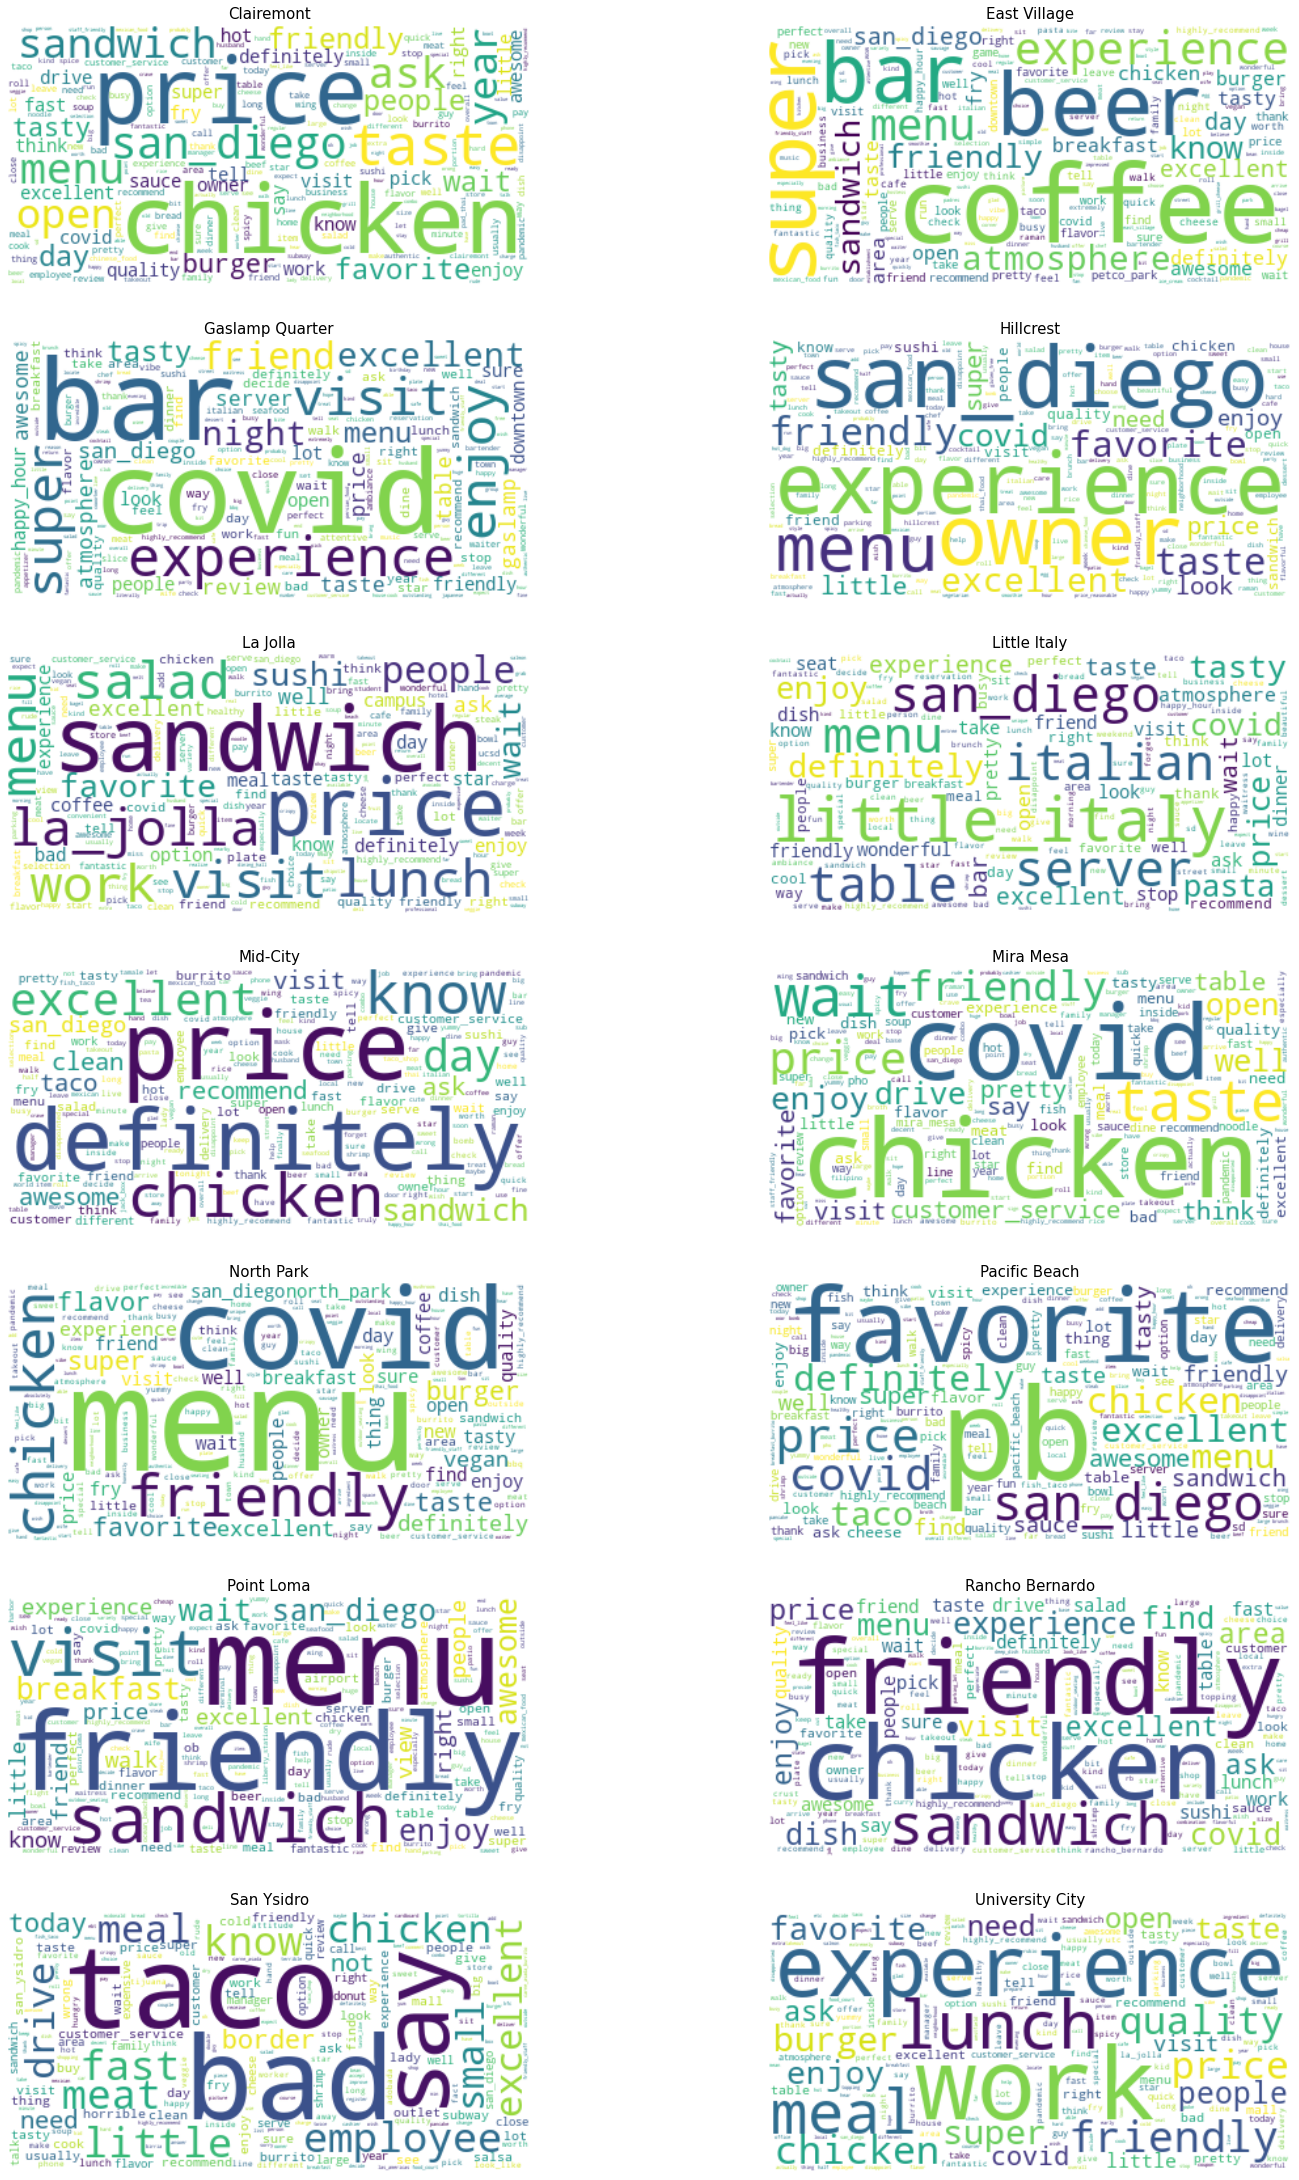

In [28]:
ncols = 2
nrows = math.ceil(len(neighborhoods) / ncols)
plt.figure(figsize=(25, 80))
neighborhoods_plot = {
    'Clairemont',
    'East Village',
    'Hillcrest',
    'La Jolla',
    'Little Italy',
    'Gaslamp Quarter',
    'Mira Mesa',
#     'MIddletown',
    'Mid-City',
#     'Mission Beach',
#     'Mission Hills',
#     'Normal Heights',
    'North Park',
#     'Ocean Beach',
    'Pacific Beach',
    'Point Loma',
    'Rancho Bernardo',
    'San Ysidro',
    'University City',
}

for i, n in enumerate(sorted(neighborhoods_plot)):
    plt.subplot(nrows, ncols, i+1)
    word_cloud(word_counts[n], title=n, random_state=random_state)

In [29]:
word_counts_rating = {
    'high': Counter(word for doc in df[df.rating>3].text_filter for word in doc),
    'low': Counter(word for doc in df[df.rating<=3].text_filter for word in doc)
}

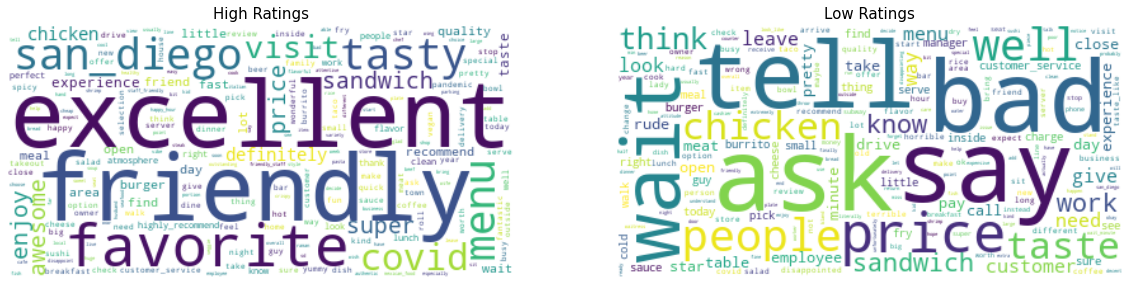

In [30]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
word_cloud(word_counts_rating['high'], title='High Ratings', random_state=random_state)
plt.subplot(1, 2, 2)
word_cloud(word_counts_rating['low'], title='Low Ratings', random_state=random_state)

# Topic Modeling

Convert reviews to a bag-of-words (BoW) format

In [31]:
dic = Dictionary(df.text_ngrams)
dic.filter_extremes(no_below=20, no_above=0.3)
corpus = [dic.doc2bow(doc) for doc in df.text_ngrams]

Train LDA model with [MALLET](http://mallet.cs.umass.edu/)

In [32]:
mallet_path = '/Users/twlim/Downloads/mallet-2.0.8/bin/mallet'
num_topics = 10
workers = 4
iterations = 1000
optimize_interval = 100

lda = LdaMallet(
    mallet_path=mallet_path,
    corpus=corpus,
    id2word=dic,
    num_topics=num_topics,
    workers=workers,
    iterations=iterations,
    optimize_interval=optimize_interval,
    random_seed=random_state
)

Print resulting topics

In [33]:
def get_topic_words(i, num_words=10):
    return lda.print_topic(i, topn=num_words).split('"')[1::2]

In [34]:
for i in range(10):
    print(get_topic_words(i, 10))

['bad', 'people', 'customer', 'work', 'customer_service', 'give', 'employee', 'star', 'guy', 'leave']
['delicious', 'fresh', 'sandwich', 'menu', 'salad', 'option', 'bowl', 'small', 'lunch', 'roll']
['great', 'service', 'place', 'delicious', 'excellent', 'friendly', 'super', 'spot', 'tasty', 'fast']
['chicken', 'flavor', 'sauce', 'fry', 'dish', 'meat', 'taste', 'hot', 'good', 'spicy']
['great', 'drink', 'nice', 'bar', 'spot', 'enjoy', 'beer', 'area', 'night', 'dinner']
['order', 'time', 'taco', 'pick', 'wait', 'burrito', 'drive', 'delivery', 'call', 'minute']
['good', 'place', 'love', 'amazing', 'price', 'favorite', 'san_diego', 'sushi', 'quality', 'recommend']
['time', 'restaurant', 'eat', 'location', 'visit', 'covid', 'open', 'find', 'day', 'year']
['staff', 'experience', 'nice', 'table', 'coffee', 'server', 'breakfast', 'enjoy', 'restaurant', 'kind']
['pizza', 'burger', 'good', 'cheese', 'taste', 'large', 'buy', 'kid', 'eat', 'add']


Select number of topic words based on maximum topic overlap

In [35]:
num_words = 25
topics = {i: set(get_topic_words(i, num_words=num_words)) for i in range(num_topics)}
topic_overlap = [len(topics[i].intersection(topics[j])) for i in range(num_topics) for j in range(i+1, num_topics)]
print(f'Maximum topic overlap: {max(topic_overlap)} words')

Maximum topic overlap: 5 words


Get possible topics and scores for all reviews

In [36]:
len([topic for topic in lda.load_document_topics()])

22047

In [37]:
df['topic'] = [topic for topic in lda.load_document_topics()]

Split topics and scores into separate columns

In [38]:
df.copy().explode('topic')

,neighborhood,text,rating,text_processed,text_ngrams,text_filter,topic
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...","(0, 0.08482646713665103)"
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...","(1, 0.10267861387899332)"
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...","(2, 0.10166814697107178)"
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...","(3, 0.09944338114506603)"
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...","(4, 0.132132326502977)"
...,...,...,...,...,...,...,...
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...","(5, 0.06949599148438575)"
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...","(6, 0.16380355136101657)"
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...","(7, 0.08822844921651078)"
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...","(8, 0.09781635532707589)"


In [39]:
df_topics = df.copy().explode('topic')
df_topics[['topic', 'score']] = df_topics.topic.to_list()
df_topics

,neighborhood,text,rating,text_processed,text_ngrams,text_filter,topic,score
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...",0,0.084826
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...",1,0.102679
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...",2,0.101668
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...",3,0.099443
0,San Ysidro,The food is good.. not many lunch selections o...,4.0,"[food, good, lunch, selection, menu, staff, wi...","[food, good, lunch, selection, menu, staff, wi...","[lunch, selection, menu, willing, adjust, exam...",4,0.132132
...,...,...,...,...,...,...,...,...
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...",5,0.069496
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...",6,0.163804
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...",7,0.088228
22046,Mira Mesa,"Not bad, not the most amazing place but practi...",3.0,"[bad, amazing, place, practical, good, filling...","[bad, amazing, place, practical, good, filling...","[bad, practical, filling, well, korean, combos...",8,0.097816


Calculate the amount topic probabilities within each neighborhood deviate from the expected probabilities

In [40]:
neighborhood_sum = df_topics.groupby(['neighborhood', 'topic'])['score'].sum()
neighborhood_pct = neighborhood_sum / neighborhood_sum.groupby('neighborhood').sum()

topic_sum = df_topics.groupby('topic')['score'].sum()
topic_pct = topic_sum / topic_sum.sum()

neighborhood_diff = neighborhood_pct - topic_pct
neighborhood_diff

neighborhood     topic
Barrio Logan     0        0.001676
                 1        0.001598
                 2        0.000989
                 3       -0.002272
                 4       -0.000237
                            ...   
University City  5       -0.000942
                 6       -0.002474
                 7        0.003508
                 8        0.000292
                 9        0.000748
Name: score, Length: 280, dtype: float64

Find either the most above-average topic for each neighborhood or all above-average topics

In [44]:
above_average = False

if above_average:
    topics = neighborhood_diff > 0
else:
    topN = 2
    topics = neighborhood_diff.reset_index().sort_values(by=['score'], ascending=False)
    topics = topics.groupby('neighborhood').head(topN).score.index

neighborhood_topics = neighborhood_diff[topics].reset_index()
neighborhood_topics = neighborhood_topics.groupby(['topic'])['neighborhood'].apply(list).reset_index()
neighborhood_topics['words'] = neighborhood_topics.topic.apply(partial(get_topic_words, num_words=num_words))
neighborhood_topics

,topic,neighborhood,words
0,0,"[San Ysidro, Otay Ranch, Clairemont, Miramar, ...","[bad, people, customer, work, customer_service..."
1,1,"[La Jolla, Grantville, Sorrento Mesa, Barrio L...","[delicious, fresh, sandwich, menu, salad, opti..."
2,2,"[Midway District, Core-Columbia, East Village,...","[great, service, place, delicious, excellent, ..."
3,3,"[Mira Mesa, Kearny Mesa, City Heights, Sorrent...","[chicken, flavor, sauce, fry, dish, meat, tast..."
4,4,"[Little Italy, Gaslamp Quarter, East Village, ...","[great, drink, nice, bar, spot, enjoy, beer, a..."
5,5,"[Otay Ranch, San Ysidro, Mid-City, Grantville,...","[order, time, taco, pick, wait, burrito, drive..."
6,6,"[City Heights, Pacific Beach, Hillcrest, Midwa...","[good, place, love, amazing, price, favorite, ..."
7,7,"[Miramar, University City]","[time, restaurant, eat, location, visit, covid..."
8,8,"[Little Italy, Marina, Gaslamp Quarter, Rancho...","[staff, experience, nice, table, coffee, serve..."
9,9,"[Mission Beach, Mid-City]","[pizza, burger, good, cheese, taste, large, bu..."


In [46]:
filename = os.path.join(data_path, '{}_review_topics.json'.format(term))
columns = ['topic', 'words', 'neighborhood']
topic_dict = neighborhood_topics[columns].to_dict(orient='records')

with open(filename, 'w') as f:
    print(json.dumps(topic_dict, indent=4), file=f)